# Implementación Básica de PINN

In [1]:
from typing import Callable
from functools import partial

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np

## Parte 1. Definición del problema
La ecuación a resolver es el modelo de crecimiento de población.
$$\frac{df}{dt} = R t(1-t)$$
Donde $f(t)$ es el radio de crecimiento de población a lo largo del tiempo y $R$ es el radio de crecimiento de población máximo. Esta ecuación tiene las condiciones de frontera:
$$f(t=0)=1$$
Sea $f_{NN}(t)$ nuestra red neuronal, así nuestra red neuronal debe cumplir:
$$\frac{df_{NN}(t)}{dt} - R t(1-t) = 0$$
Nuestra red neuronal requiere ser entrenada, para ello definamos la función de pérdida con el MSE. Sea $\{x_j\}_{j=1,...,m}$ el conjunto de puntos seleccionados, entonces definimos la función de pérdida de la ecuación diferencial por:
$$\mathcal{L}_{DE} = \frac{1}{M} \sum_{j=1}^M \left( \left. \frac{df_{NN}}{dt} \right|_{x_j} - R x_j(1-x_j) \right)^2$$
Sin embargo, también se requiere una función de pérdida debido a las conficiones de frontera:
$$\mathcal{L}_{BC} = \left( f_{NN} (t_0) -1 \right)^2,\quad t_0=0$$
Por tanto, la función de pérdida completa es:
$$\mathcal{L} = \mathcal{L}_{DE} + \mathcal{L}_{BC}$$
El objetivo es disminuir esta función de pérdida. Usaremos el gradciente descendente.

## Parte 2. Definición de la Red Neuronal
Usaremos una red neuronal multicapa, con un entradas y capas dadas por el usuario. Además, nuestra función de activación será $\tanh x$.

In [2]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
    
        super().__init__()
        # Creamos una transformaciión lineal de la entrada a la capa oculta
        # 1 capa oculta
        self.layer_in = nn.Linear(1, dim_hidden)
        # De la capa oculta obtenemos al salida
        self.layer_out = nn.Linear(dim_hidden, 1)
        
        # Creamos las capas ocultas
        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        # Funcion de activacion
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            # Activamos las entradas
            out = self.act(layer(out))
        return self.layer_out(out)

In [3]:
# Función para calculr las derivadas 
def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)

def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    # Obtiene las derivadas en casod e requerir varias
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

In [4]:
# Obtención de la función de pérdida
def compute_loss(
    nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    # Función de pérdida de frontera
    interior_loss = df(nn, x) - R * x * (1 - x)
    # Punto frontera
    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - F0
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss

In [5]:
# Función de entrenamiento
def train_model(nn: NNApproximator,
                loss_fn: Callable,
                learning_rate: int = 0.01,
                max_epochs: int = 1_000,
            ) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


In [6]:
# Función de gradiente, Retropropagación
def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)

In [7]:
# Constantes
R = 1.0
F0 = 1.0

# Intervalo de t
domain = [0.0, 1.0]
x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
x = x.reshape(x.shape[0], 1)

# Creación de la red
nn_approximator = NNApproximator(4, 10)
assert check_gradient(nn_approximator, x)

# train the PINN
# Función de pérdida
loss_fn = partial(compute_loss, x=x, verbose=True)
# Entrenamos la red
nn_approximator_trained, loss_evolution = train_model(
nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000)

# Puntos del eje x para graficar
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

    
    

Epoch: 0 - Loss: 1.358452
Epoch: 1000 - Loss: 0.003157
Epoch: 2000 - Loss: 0.000325
Epoch: 3000 - Loss: 0.000288
Epoch: 4000 - Loss: 0.000259
Epoch: 5000 - Loss: 0.000235
Epoch: 6000 - Loss: 0.000216
Epoch: 7000 - Loss: 0.000199
Epoch: 8000 - Loss: 0.000185
Epoch: 9000 - Loss: 0.000173
Epoch: 10000 - Loss: 0.000162
Epoch: 11000 - Loss: 0.000152
Epoch: 12000 - Loss: 0.000144
Epoch: 13000 - Loss: 0.000136
Epoch: 14000 - Loss: 0.000129
Epoch: 15000 - Loss: 0.000122
Epoch: 16000 - Loss: 0.000116
Epoch: 17000 - Loss: 0.000111
Epoch: 18000 - Loss: 0.000106
Epoch: 19000 - Loss: 0.000101


In [8]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy())


No handles with labels found to put in legend.


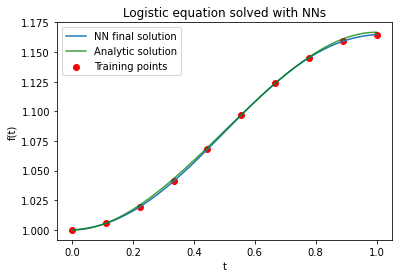

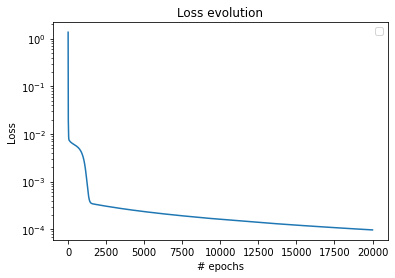

In [9]:
# plotting
fig, ax = plt.subplots()

f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)

ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
ax.plot(
        x_eval.detach().numpy(),
        numeric_solution.y.T,
        label=f"Analytic solution",
        color="green",
        alpha=0.75,
    )
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()